# Microtask: Explore Toolhub Data

In [1]:
import json  # will let us print out the response in a prettier format
import requests  # necessary to make API calls
import datetime # for Task #2
import matplotlib.pyplot as plt # for data visualization

# configure API session parameters

# user_agent helps identify the request if there is an issue and is best practice
REQUEST_LABEL = 'Outreachy 25 Toolhub Microtask'

# NOTE: it's considered best practice to include contact info in user agents
USER_INFO = 'Phabricator user: NicoleLBee'

headers = {'User-Agent': f'{REQUEST_LABEL} - {USER_INFO}'}

TOOLS_API_ENDPOINT = "https://toolhub.wikimedia.org/api/tools"
SEARCH_API_ENDPOINT = "https://toolhub.wikimedia.org/api/search/tools"
toolname = "pywikibot"
url = f'{TOOLS_API_ENDPOINT}/{toolname}/'

#response = requests.get(url, headers=headers)
#if response.status_code == 200:
#    json_formatted_response = json.dumps(response.json(), indent=2)
#    print(json_formatted_response)
#else:
#    print(response.status_code)

## TASK SET 1

In [2]:
# TODO: Write a function that takes a tool name,
# and returns all the missing fields as a list.

def list_missing_fields(target):
    url = f'{TOOLS_API_ENDPOINT}/{target}/'
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        api_response = response.json()
        empty_fields = []
        for key in api_response["annotations"]:
            # If the tool has not been deprecated, then the absence of a value for "replaced_by" is irrelevant
            if key == "replaced_by" and (api_response["deprecated"] == False or api_response["annotations"]["deprecated"] == False):
                 continue
            # Although the following lines are unwieldy, it was specified that a piece of information is missing only if it is absent in both the Core and Annotations layers, and therefore I need to check both sources.
            # This only works if the key exists in both places, so I check for that first.
            elif (key in api_response):
                    if (api_response[key] == [] or api_response[key] == None) and (api_response["annotations"][key] == [] or api_response["annotations"][key] == None):
                        empty_fields.append(key)
            elif api_response["annotations"][key] == [] or api_response["annotations"][key] == None:
                empty_fields.append(key)
        return empty_fields
    else:
        print(response.status_code)


### TESTING TASK 1:  

Examining the output of the fetch request in the example code block, I can see that, within the "annotations" dict of pywikibot, the following fields have no value:
 ```
    "wikidata_qid": null,
    "replaced_by": null,
    "for_wikis": [],
    "icon": null,
    "tool_type": null,
    "repository": null,
    "api_url": null,
    "user_docs_url": [],
    "feedback_url": [],
    "privacy_policy_url": [],
    "translate_url": null,
    "bugtracker_url": null
```

However, most of these have values contained within the Core tool info.  If I eliminate the ones that are assigned values in the Core tool info, and eliminate "replaced_by" (since the tool is not deprecated, the absence of a value here is expected), I'm left with the following empty fields:

```
wikidata_qid  
api_url  
feedback_url  
privacy_policy_url
```

So I would expect that calling `list_missing_fields("pywikibot")` would return the following list: `['wikidata_quid', 'api_url', 'feedback_url', 'privacy_policy_url']`

In [3]:
list_missing_fields("pywikibot")

['wikidata_qid', 'api_url', 'feedback_url', 'privacy_policy_url']

### TESTING TASK 1: PART 2

I'll try another: `mm_wikidata_todo`  When I plug the toolname into the code block found at the beginning of the document, I can see that the following fields in the "annotations" dict have no value:  

```
  "annotations": {
    "wikidata_qid": null,
    "replaced_by": null,
    "for_wikis": [],
    "icon": null,
    "api_url": null,
    "developer_docs_url": [],
    "user_docs_url": [],
    "feedback_url": [],
    "privacy_policy_url": [],
    "translate_url": null,
  },
  ```

Checking against the relevant Core values, 

```
 "deprecated": false,
  "replaced_by": null,
  "experimental": false,
  "for_wikis": [],
  "icon": null,
  "license": null,
  "sponsor": [],
  "available_ui_languages": [],
  "technology_used": [],
  "tool_type": null,
  "api_url": null,
  "developer_docs_url": [],
  "user_docs_url": [],
  "feedback_url": [],
  "privacy_policy_url": [],
  "translate_url": null,
  "bugtracker_url": null,
  ```
  
  And I can see that the following fields have no value in either Annotations or the Core:
  ```
  wikidata_qid,
  replaced_by,
  for_wikis,
  icon,
  api_url,
  developer_docs_url,
  user_docs_url,
  feedback_url,
  privacy_policy_url,
  translate_url
  ```
  
  Considering that my function would eliminate `replaced_by`,  I would expect that `list_missing_fields("mm_wikidata_todo")` would return the following list:
  
  ```
  [ 'wikidata_qid',
  'for_wikis',
  'icon',
  'api_url',
  'developer_docs_url',
  'user_docs_url',
  'feedback_url',
  'privacy_policy_url',
  'translate_url' ]
  ```

In [4]:
list_missing_fields("mm_wikidata_todo")

['wikidata_qid',
 'for_wikis',
 'icon',
 'api_url',
 'user_docs_url',
 'feedback_url',
 'privacy_policy_url',
 'translate_url']

### **TODO**: Consider all the fields that are editable. ##
1. Should they all be considered equally valuable from the point of view of a user searching for a tool to use in their workflows?
2. Or a user that is looking for a tool to contribute to? Why or why not?
3. Which are, according to you, the three most valuable fields? Which are the least valuable? Explain your reasoning.

#### Answers

1. In my opinion, they would certainly not be equally valuable from the PoV of a user searching for a tool to use.  A user who wants to make use of a tool would be most interested in the context in which the tool would be used (i.e., "tool_type") or in documentation pertaining to the tool's use (e.g., "user_docs_url").

2. On the other hand, a user who was looking to make a contribution would be more interested in fields such as "repository," "developer_docs_url," or "bug_tracker_url."  Users will seek information that will assist them in achieving their goals, so naturally users with different goals (in this case, working *with* a tool vs. working *on* a tool) will be interested in different pieces of information.

3. I would like include "replaced_by" in both the most *and* least valuable lists, simply because if the tool isn't depreciated, then the value of the field is of no importance whatsoever, but if the tool *is* depreciated, then it is *extremely* important.  (I know I keep banging on about this field.)  But since that feels a bit like cheating, I'll consider "replaced_by" a *special* case and list the following:

**Most valuable**
1. repository: A well-written repository would likely contain information pertaining to the following fields as well: "developer_docs_url", "user_docs_url", "feedback_url", "deprecated" and "bugtracker_url."  In this way one entry can cover multiple bases, as it were.  If we had one thing to encourage contributors to this project to look for and add, it would be (in my opinion) a repository.

2. deprecated:  This field provides critical information: a non-functional tool is of no use to a user and a contributor's time would be better spent working on the replacement tool

3. user_docs_url: What is the use of having access to a tool if you can't figure out how to use it? 


**Least valuable**
1.  icon: This is purely cosmetic and contains no useful information either for a user or a contributor.

2.  wikidata_qid: A string for use with the Wikidata query service, apparently, but I cannot find any information about how this would be generated.  I'm actually surprised that this isn't auto-generated when the tool is created.  Is this connected to a database entry somewhere?  It's not clear to me how a user would be able to input a meaningful id.  And if this information has no meaning, then it has no value and is not useful as a search parameter.

3.  translate_url: "A link to the tool's translation interface."  I am honestly not sure what this means.  A link to translated documentation?  Does it duplicate "available_ui_languages"?  It is unclear, and thus not particularly useful.

## TASK SET 2

In [5]:
# TODO: Write a function that returns a dict where the keys are tool names, and the values are tuples:
# {<tool name>: (<number of missing fields>, <days since the tool was last edited>)}.

# Make a request to the /api/tools endpoint, gather the values from the "results" dict: for each entry, "name"  and "modified_date" (OR "created_date", if it's never been modified
# Run it through a modified version of the the function that I wrote above and return the length of the dict to fill the <number of missing fields> bit
# Push all of that info to an entry in the dict.

# First I will rewrite the above function to serve as a callback function.  This time it will only return the length of the list, e.g. the number of empty fields.

def count_missing_entries(entry):
    empty_fields = []
    for key in entry["annotations"]:
        if key == "replaced_by" and (entry["deprecated"] == False or entry["annotations"]["deprecated"] == False):
            continue
        elif (key in entry):
            if (entry[key] == [] or entry[key] == None) and (entry["annotations"][key] == [] or entry["annotations"][key] == None):
                        empty_fields.append(key)
        elif entry["annotations"][key] == [] or entry["annotations"][key] == None:
             empty_fields.append(key)
    return len(empty_fields)
    
# The value of the "modified_date" and "created_date" fields does not appear to be in iso format, or at least datetime.date.fromisoformat doesn't want to recognize it
# What a bummer!  So I'll write a function to make a proper date out of the value.  I only need the year, month and day.

def parse_date(date):
    slice_point = date.index('T')
    year, month, day = date[0:slice_point].split('-')
    return datetime.date(int(year), int(month), int(day))

# I'll write another function to calculate the number of days elapsed between the current date and the value of the "modified_date" or the "created_date" field

def calc_days_elapsed(entry_date): 
    current_date = datetime.date.today()
    past_date = parse_date(entry_date)
    return (current_date - past_date).days

# Then I will write a cut-down version of the function to ensure that it will produce the results that I want using a test data set and those functions I just wrote.

def build_tool_dict_test(target):
    tool_entries = {}
    data_set = target["results"]
    for entry in data_set:
        # I want to calculate days elapsed based on the value of "modified_date" if it exists and the value of "created_date" if it does not.
        date = entry["modified_date"] or entry["created_date"]
        tool_entries[entry["name"]] = (count_missing_entries(entry), calc_days_elapsed(date))
    return tool_entries     

### Testing the function(s)

I'll test the core functionality by taking information from the following dict, which is structured in the same way as the result of an actual fetch request to the /api/tools endpoint, and contains the data from "mm_wikidata_todo" and "pywikibot" plus a modified "pywikibot" entry that 
contains no modified date.

#### Mock data set

In [6]:
mock_data = {
    "count": 2702,
    "next": "https://toolhub.wikimedia.org/api/search/tools/?page=2",
    "previous": None,
    "results": [
{
      "name": "mm_wikidata_todo",
      "title": "Wikidata Todo",
      "description": "Shows you little things you can do on Wikidata.",
      "url": "http://tools.wmflabs.org/wikidata-todo",
      "keywords": [
        "wikidata",
        "task"
      ],
      "author": [
        {
          "name": "Magnus Manske"
        }
      ],
      "repository": "https://bitbucket.org/magnusmanske/wikidata-todo",
      "subtitle": None,
      "openhub_id": None,
      "url_alternates": [],
      "bot_username": None,
      "deprecated": False,
      "replaced_by": None,
      "experimental": False,
      "for_wikis": [],
      "icon": None,
      "license": None,
      "sponsor": [],
      "available_ui_languages": [],
      "technology_used": [],
      "tool_type": None,
      "api_url": None,
      "developer_docs_url": [],
      "user_docs_url": [],
      "feedback_url": [],
      "privacy_policy_url": [],
      "translate_url": None,
      "bugtracker_url": None,
      "annotations": {
        "wikidata_qid": None,
        "deprecated": False,
        "replaced_by": None,
        "experimental": False,
        "for_wikis": [],
        "icon": None,
        "available_ui_languages": [
          "en"
        ],
        "tool_type": "web app",
        "repository": "https://bitbucket.org/magnusmanske/wikidata-todo/src/master/",
        "api_url": None,
        "developer_docs_url": [
          {
            "url": "https://toolhub.mediawiki.com",
            "language": "en"
          }
        ],
        "user_docs_url": [],
        "feedback_url": [],
        "privacy_policy_url": [],
        "translate_url": None,
        "bugtracker_url": "https://bitbucket.org/magnusmanske/wikidata-todo/issues?status=new&status=open"
      },
      "_schema": None,
      "_language": "en",
      "origin": "crawler",
      "created_by": {
        "id": 9,
        "username": "Toolhub"
      },
      "created_date": "2021-10-10T21:04:18.627185Z",
      "modified_by": {
        "id": 428,
        "username": "Sabina.zaripova"
      },
      "modified_date": "2022-10-16T10:02:45.287384Z"
    },
        
    {
  "name": "pywikibot",
  "title": "Pywikibot",
  "description": "Python library and collection of scripts that automate work on MediaWiki sites",
  "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot",
  "keywords": [],
  "author": [
    {
      "name": "Pywikibot team"
    }
  ],
  "repository": "https://gerrit.wikimedia.org/g/pywikibot/core",
  "subtitle": None,
  "openhub_id": None,
  "url_alternates": [],
  "bot_username": None,
  "deprecated": False,
  "replaced_by": None,
  "experimental": False,
  "for_wikis": [
    "*"
  ],
  "icon": "https://commons.wikimedia.org/wiki/File:Pywikibot_MW_gear_icon.svg",
  "license": "MIT",
  "sponsor": [],
  "available_ui_languages": [],
  "technology_used": [
    "python"
  ],
  "tool_type": "coding framework",
  "api_url": None,
  "developer_docs_url": [
    {
      "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot/Development",
      "language": "en"
    }
  ],
  "user_docs_url": [
    {
      "language": "en",
      "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot"
    },
    {
      "url": "https://doc.wikimedia.org/pywikibot/",
      "language": "en"
    }
  ],
  "feedback_url": [],
  "privacy_policy_url": [],
  "translate_url": "https://translatewiki.net/wiki/Translating:Pywikibot",
  "bugtracker_url": "https://phabricator.wikimedia.org/tag/pywikibot/",
  "annotations": {
    "wikidata_qid": None,
    "deprecated": False,
    "replaced_by": None,
    "experimental": False,
    "for_wikis": [],
    "icon": None,
    "available_ui_languages": [
      "en"
    ],
    "tool_type": None,
    "repository": None,
    "api_url": None,
    "developer_docs_url": [
      {
        "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot",
        "language": "en"
      }
    ],
    "user_docs_url": [],
    "feedback_url": [],
    "privacy_policy_url": [],
    "translate_url": None,
    "bugtracker_url": None
  },
  "_schema": None,
  "_language": "en",
  "origin": "api",
  "created_by": {
    "id": 10,
    "username": "JJMC89"
  },
  "created_date": "2021-10-12T20:26:29.012245Z",
  "modified_by": {
    "id": 3,
    "username": "BDavis (WMF)"
  },
  "modified_date": "2022-05-21T17:22:54.441791Z"
},
            {
  "name": "pywikifake",
  "title": "Pywikibot",
  "description": "Python library and collection of scripts that automate work on MediaWiki sites",
  "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot",
  "keywords": [],
  "author": [
    {
      "name": "Pywikibot team"
    }
  ],
  "repository": "https://gerrit.wikimedia.org/g/pywikibot/core",
  "subtitle": None,
  "openhub_id": None,
  "url_alternates": [],
  "bot_username": None,
  "deprecated": False,
  "replaced_by": None,
  "experimental": False,
  "for_wikis": [
    "*"
  ],
  "icon": "https://commons.wikimedia.org/wiki/File:Pywikibot_MW_gear_icon.svg",
  "license": "MIT",
  "sponsor": [],
  "available_ui_languages": [],
  "technology_used": [
    "python"
  ],
  "tool_type": "coding framework",
  "api_url": None,
  "developer_docs_url": [
    {
      "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot/Development",
      "language": "en"
    }
  ],
  "user_docs_url": [
    {
      "language": "en",
      "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot"
    },
    {
      "url": "https://doc.wikimedia.org/pywikibot/",
      "language": "en"
    }
  ],
  "feedback_url": [],
  "privacy_policy_url": [],
  "translate_url": "https://translatewiki.net/wiki/Translating:Pywikibot",
  "bugtracker_url": "https://phabricator.wikimedia.org/tag/pywikibot/",
  "annotations": {
    "wikidata_qid": None,
    "deprecated": False,
    "replaced_by": None,
    "experimental": False,
    "for_wikis": [],
    "icon": None,
    "available_ui_languages": [
      "en"
    ],
    "tool_type": None,
    "repository": None,
    "api_url": None,
    "developer_docs_url": [
      {
        "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot",
        "language": "en"
      }
    ],
    "user_docs_url": [],
    "feedback_url": [],
    "privacy_policy_url": [],
    "translate_url": None,
    "bugtracker_url": None
  },
  "_schema": None,
  "_language": "en",
  "origin": "api",
  "created_by": {
    "id": 10,
    "username": "JJMC89"
  },
  "created_date": "2021-10-12T20:26:29.012245Z",
  "modified_by": None,
  "modified_date": None
}
    ]
}

#### Testing the subfunctions

In [7]:
# I can test count_missing_entries() by taking the first result in the mock data set.  Its the entry for "mm_wikidata_todo," which I know has 8 missing fields, so I would expect the function to return 8.

task2_count_test = mock_data["results"][0]

print(count_missing_entries(task2_count_test))

8


In [8]:
# I can test parse_date() by passing the date string from the "mm_wikidata_todo" entry
# The string is "2022-10-16T10:02:45.287384Z", so I would expect the result to be identical to the result of datetime.date(2022, 10, 16)

task2_date_test = mock_data["results"][0]["modified_date"]
print(task2_date_test)
print(datetime.date(2022, 10, 16))
print(parse_date(task2_date_test))

2022-10-16T10:02:45.287384Z
2022-10-16
2022-10-16


In [9]:
# I can test calc_days_elapsed() by passing the same date string and comparing it to the current date.
# October 16th is not very long ago; at the time I write this (October 18th) I expect to see a return value of 2 (+ however many days it's been since the 18th)

print(calc_days_elapsed(task2_date_test))

3


### Testing the full function

Finally we put them all together and call `build_tool_dict_test()`

I already know that "mm_wikidata_todo" has 8 missing fields, and "pywikibot" has 4.
Looking at the dates, I can see that "mm_wikidata_todo" was last modified on October 16, 2022.  "pywikibot" was modified on May 21, 2022 and created on October 12, 2021.  (The creation date is what should be referenced in the third entry of the list, as I have deliberately removed the value of "modified_date".)

Therefore, based on today being October 18th, I would expect `build_tool_dict_test(mock_data)` to return the following:
```
{
    'mm_wikidata_todo': (8, 2),
    'pywikibot': (4, 150),
    'pywikifake': (4, 371)
 }
```

The estimated dates will be a little off by the time you see this!  Add however many days it's been since the 18th!

In [10]:
build_tool_dict_test(mock_data)

{'mm_wikidata_todo': (8, 3), 'pywikibot': (4, 151), 'pywikifake': (4, 372)}

In [11]:
# As I am satisfied that my function is working properly, I can incorporate the actual fetch request.

def build_tool_dict():
    url = f'{TOOLS_API_ENDPOINT}'
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        api_response = response.json()
        tools = api_response["results"]
        while api_response["next"]:
            api_response = requests.get(api_response["next"], headers=headers).json()
            tools.extend(api_response["results"])
        tool_entries = {}
        for entry in tools:
            date = entry["modified_date"] or entry["created_date"]
            tool_entries[entry["name"]] = (count_missing_entries(entry), calc_days_elapsed(date))
        return tool_entries
    else:
        print(response.status_code)

# I tested this function by setting the return value to len(tool_entries) and received a value of 2702, which is equal to the maximum count of documents that I received while playing with the API
# Therefore, I am confident that the function is functioning.  I wouldn't want to try to print the results of this one!

### TODO: Visualize this data in a meaningful way. 

I decided that I would like to create a visualization to represent how many tools are missing fields: as in, how many tools are missing just 1 field, or 2 fields, etc.  Are many tools missing fields?

For that, I decided to iterate over the results of `build_tool_dict()` and determine how many times certain values appear in `<number of missing fields>`

My first step was to build a function that I could test, using the tiny data set and build_tool_dict_test()

I want the function to return the data in a sorted dictionary, from fewest tools missing to most tools missing.

In [12]:
def convert_to_sorted(data):
    data_plot = {}
    for key, value in data.items():
        new_key = value[0]
        if new_key in data_plot:
            data_plot[new_key] += 1
        else:
            data_plot[new_key] = 1
    return dict(sorted(data_plot.items()))

I already know that `build_tool_dict_test(mock_data)` will return the following:
```
{'mm_wikidata_todo': (8, 2), 'pywikibot': (4, 150), 'pywikifake': (4, 371)}
```

One tool is missing eight items, and two tools are missing 4 items.  Therefore I would expect that passing that dict into `convert_to_sorted()` would give me the following result: `{4: 2, 8: 1}`

I also wanted a second test, so wrote another dummy dict.

In [13]:
test1 = {'mm_wikidata_todo': (8, 2), 'pywikibot': (4, 150), 'pywikifake': (4, 371)}
test2 = {'mm_wikidata_todo': (8, 2), 'pywikibot': (4, 150), 'pywikifake': (4, 371), 'mm_wikidata_todo2': (3, 2), 'pywikibot2': (4, 150), 'pywikifake2': (4, 371)}
print(convert_to_sorted(test1))  # I expect to see {4: 2, 8: 1}
print(convert_to_sorted(test2)) # I expect to see {3: 1, 4: 4, 8: 1}


{4: 2, 8: 1}
{3: 1, 4: 4, 8: 1}


In [14]:
# Let's tie it all together with the output from build_tool_dict()

entries = build_tool_dict()
plottable_data = convert_to_sorted(entries)
print(plottable_data)

{0: 1, 1: 1, 3: 7, 4: 6, 5: 10, 6: 23, 7: 32, 8: 69, 9: 89, 10: 109, 11: 759, 12: 450, 13: 1146}


Text(0, 0.5, 'Number of tools')

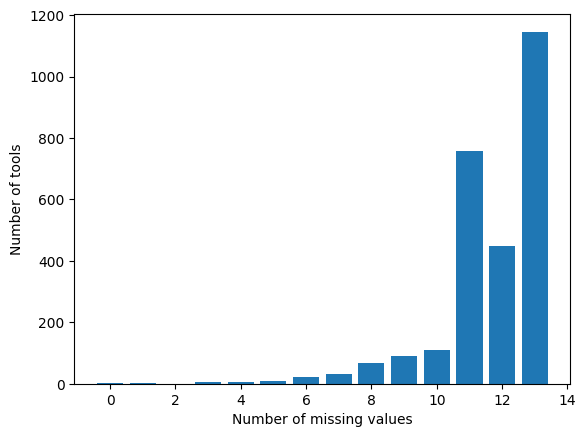

In [15]:
# Fabulous!  Now I can finally visualize the data!  

plt.bar(plottable_data.keys(), plottable_data.values())
plt.xlabel('Number of missing values')
plt.ylabel('Number of tools')


So there are a few tools that are missing a few values, and a lot of tools that are missing a **lot** of values.  In fact, of the 16 values in the "Annotations" set, the majority of tools are missing almost all of them.  I'm not sure how meaningful that is, except that it does suggest that there's a lot of work to be done! 

I'm far more interested in the second part of the task:  finding and visualizing which fields are most frequently missing.

My objective is to take the data from Toolhub and return a dict with the following structure: `{<toolname>: <# of times that it's missing>}`
My convert_to_sorted() function will be able to manage this; I just need to write new functions that incorporate both it and aspects of list_missing_fields() and build_tool_dict()

### TODO: Which fields are most frequently missing? 

In [16]:
# Let's start with writing some functions that will work with my mock data set.  Or, rather, modifying the functions I already wrote.
# I can grab items from the mock data dict to assist with testing

todo_test = mock_data["results"][0]
pywiki_test = mock_data["results"][1]
pyfake_test = mock_data["results"][2]

def list_fields_from_item(item):
    empty_fields = []
    for key in item["annotations"]:
        if key == "replaced_by" and (item["deprecated"] == False or item["annotations"]["deprecated"] == False):
            continue
        elif (key in item):
            if (item[key] == [] or item[key] == None) and (item["annotations"][key] == [] or item["annotations"][key] == None):
                        empty_fields.append(key)
        elif item["annotations"][key] == [] or item["annotations"][key] == None:
            empty_fields.append(key)
    return empty_fields

print(list_fields_from_item(todo_test)) # should print [ 'wikidata_qid', 'for_wikis', 'icon', 'api_url', 'developer_docs_url', 'user_docs_url', 'feedback_url', 'privacy_policy_url', 'translate_url' ]
print(list_fields_from_item(pywiki_test)) # should print ['wikidata_qid', 'api_url', 'feedback_url', 'privacy_policy_url']
print(list_fields_from_item(pyfake_test))  # should print ['wikidata_qid', 'api_url', 'feedback_url', 'privacy_policy_url']

['wikidata_qid', 'for_wikis', 'icon', 'api_url', 'user_docs_url', 'feedback_url', 'privacy_policy_url', 'translate_url']
['wikidata_qid', 'api_url', 'feedback_url', 'privacy_policy_url']
['wikidata_qid', 'api_url', 'feedback_url', 'privacy_policy_url']


In [17]:
def compile_missing(data_set):
    tool_entries = {}
    for entry in data_set:
        tool_entries[entry["name"]] = list_fields_from_item(entry)
    return tool_entries   

new_dataset = compile_missing(mock_data["results"])
print(new_dataset)

# I would expect to receive the following:
# {
#    'mm_wikidata_todo': ['wikidata_qid', 'for_wikis', 'icon', 'api_url', 'user_docs_url', 'feedback_url', 'privacy_policy_url', 'translate_url'],
#    'pywikibot': ['wikidata_qid', 'api_url', 'feedback_url', 'privacy_policy_url'],
#    'pywikifake': ['wikidata_qid', 'api_url', 'feedback_url', 'privacy_policy_url']
# }


{'mm_wikidata_todo': ['wikidata_qid', 'for_wikis', 'icon', 'api_url', 'user_docs_url', 'feedback_url', 'privacy_policy_url', 'translate_url'], 'pywikibot': ['wikidata_qid', 'api_url', 'feedback_url', 'privacy_policy_url'], 'pywikifake': ['wikidata_qid', 'api_url', 'feedback_url', 'privacy_policy_url']}


In [18]:
# This time I would like to sort the plottable data by the values and not the keys, so that the results will be ordered from the least-often-missing value to the most-often-missing.
# So here's a function that will do that:

def sort_by_value(dataset):
    return dict(sorted(dataset.items(), key=lambda x:x[1]))

# I'll quickly test that, too.

sample_ages = {'Mark': 10, 'Nathaniel': 11, 'Alex': 15, 'Natalie': 14, 'Leo': 2}

print(sort_by_value(sample_ages))  # Would expect {'Leo': 2, 'Mark': 10, 'Nathaniel': 11, 'Natalie': 14, 'Alex': 15}

{'Leo': 2, 'Mark': 10, 'Nathaniel': 11, 'Natalie': 14, 'Alex': 15}


In [19]:
# And finally, the function that will iterate through the dict that I just created and tally up the times that the tool names appear.
# The results will pass through the sorting function, which will sort them from "least often missing" to "most often missing."

def tally_missing_fields(data):
    data_plot = {}
    for key, value in data.items():
        for entry in value:
            new_key = entry
            if new_key in data_plot:
                data_plot[new_key] += 1
            else:
                data_plot[new_key] = 1
    return sort_by_value(data_plot)

print(tally_missing_fields(new_dataset))

# I'm using the results I got earlier.  Based on those results, I would expect this function call to return the following:
# { 'for_wikis': 1, 'icon': 1, 'user_docs_url': 1, 'translate_url': 1, 'wikidata_qid': 3, 'api_url': 3, 'feedback_url': 3, 'privacy_policy_url': 3 }

{'for_wikis': 1, 'icon': 1, 'user_docs_url': 1, 'translate_url': 1, 'wikidata_qid': 3, 'api_url': 3, 'feedback_url': 3, 'privacy_policy_url': 3}


In [20]:
# And, finally, tie them all together with the fetch request.  

def build_missing_dict():
    url = f'{TOOLS_API_ENDPOINT}'
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        api_response = response.json()
        tools = api_response["results"]
        while api_response["next"]:
            api_response = requests.get(api_response["next"], headers=headers).json()
            tools.extend(api_response["results"])
        missing_entries = compile_missing(tools)
        missing_dict = tally_missing_fields(missing_entries)
        return missing_dict
    else:
        print(response.status_code)
        
missing_tool_dict = build_missing_dict()
print(missing_tool_dict)

{'tool_type': 1670, 'repository': 1894, 'user_docs_url': 1958, 'available_ui_languages': 2364, 'bugtracker_url': 2419, 'developer_docs_url': 2586, 'for_wikis': 2636, 'api_url': 2647, 'feedback_url': 2653, 'icon': 2669, 'wikidata_qid': 2679, 'translate_url': 2681, 'privacy_policy_url': 2692}


Text(0.5, 1.0, 'Fields most often missing a value')

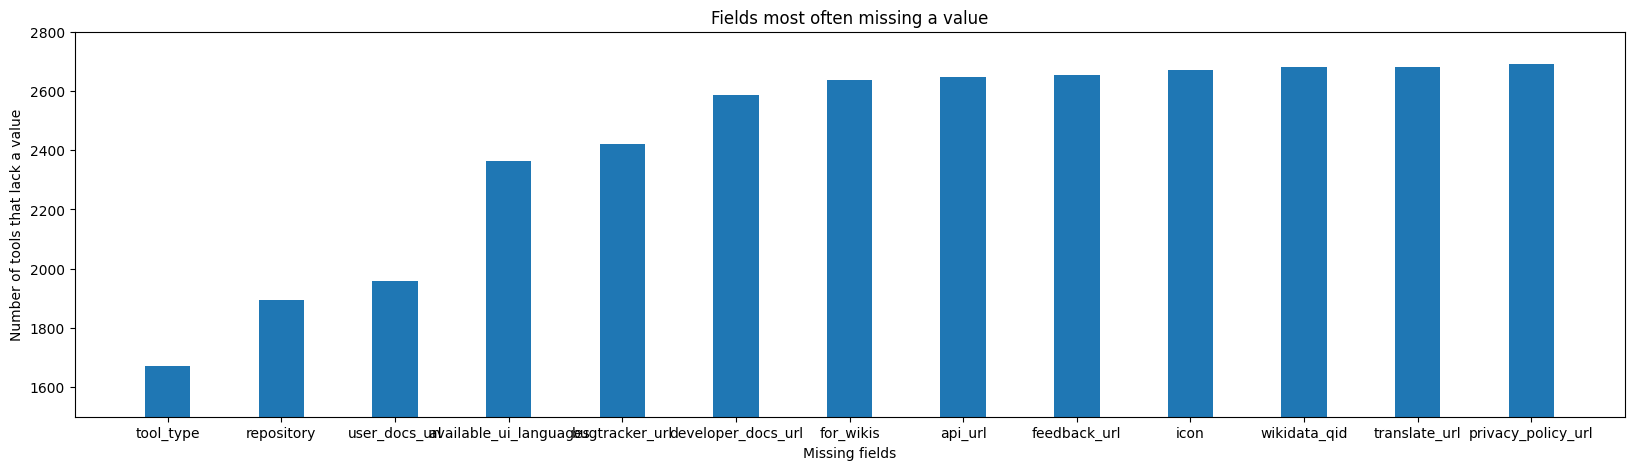

In [21]:
plt.figure(figsize=(20, 5))
plt.ylim((1500,2800))
plt.bar(missing_tool_dict.keys(), missing_tool_dict.values(), width=0.4)
plt.xlabel('Missing fields')
plt.ylabel('Number of tools that lack a value')
plt.title('Fields most often missing a value')

So what we have here is a very long-winded way of saying that the most missing values are:  

1. privacy_policy_url (2692 out of 2702 tools)
2. translate_url (2681)
3. wikidata_qid (2679)
4. icon (2669)
5. feedback_url (2653)
6. api_url (2647)
7. for_wikis (2636)
8. developer_docs_url (2586)
9. bugtracker_url (2419)
10. available_ui_languages (2364)
11. user_docs_url (1958)
12. repository (1893)
13. tool_type (1670)

In other words, of the fields in the "Annotations" set, "deprecated" and "experimental" **always** have values (no doubt because they are automatically given a value of `False` when the tool is created), "replaced_by" was stripped out by my own function, and the rest almost **never** have values.  Yikes!

Another way to find tools with missing info is via the "missing" facet in search results. 

* This link will take you to a page with search results corresponding to a search for "all the tools" https://toolhub.wikimedia.org/search?ordering=-score&page=1&page_size=12
* Observe the left side of the screen, where there is a list of search facets. The first is called "Tool type", and you can see that there are 1600+ tools missing this info
* This "missing" facet can be retrieved from the `/api/search/tools` endpoint. Go back to the [API docs](https://toolhub.wikimedia.org/api-docs), and play around with this endpoint until you feel you understand it. You can also perform various searches in Toolhub, each time observing the results you get, and the query parameters in your browser's search bar. Similarly, if you are comfortable with your browser's developer tools, you can use these to observe the HTTP requests and responses.

## Task set 3

In [22]:
# TODO: Just as in task set 1, write a function that takes a tool name,
# and returns all the missing fields as a list. However this time,
# use the /api/search/tools endpoint.

# According to you, which of the two endpoints is most suitable
# for retrieving missing records, and why? 

## Implementation details

The web application will present users with small tasks, such as "This tool is missing a link to its source code, can you find one?" These tasks will be sourced from a task queue, in which the tasks are ideally ordered from most to least "important".

**TODO**: Reflect on the following questions, and try to answer them to the best of your ability. These are open-ended questions and there's likely more than one good way to do things. Explaining your reasoning and discussing the pros and cons of different approaches is more important than arriving at the "right" answer.

### Task set 4

1. How should we define "important"? In other words, according to what criteria do you think priority in the task queue should be established?
2. The user should have the option to skip a task and move on to the next one. A reason for skipping could be that the user tried to find the requested information, but failed. Do you think we should gather this information, for instance by having the user check a box indicating their "skip reason" before being able to click skip? What other possible skip reasons could you think of. Could this information be useful when deciding which tasks to show to which users, when to show a given task again, etc.?
3. If more than one user is connected to the application and working on tasks at the same time, how would you make sure they are not presented with the same tasks?

3. The first thing that comes to my mind is 